In [25]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rcParams['font.sans-serif'] = ['SimHei', 'Heiti TC', 'PingFang HK', 'Microsoft YaHei', 'SimSun']  # 优先级从左到右
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号


main_df = pd.read_csv('data/init.csv')

main_df.set_index('timestamp', inplace=True)




# # 将所有数值列转换为float类型
# df_15min = df_15min.astype(float)
# df_1h = df_1h.astype(float)

# 检查数据类型

In [29]:
# 按照时间戳索引升序排序
main_df.sort_index(ascending=True, inplace=True)


In [30]:
main_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions'], dtype='object')

## 特征 ##

In [31]:
import pandas as pd
import numpy as np

def calculate_indicators(df, rsi_period=14, bb_period=20):
    # 计算RSI
    # 计算价格变化
    delta = df['close'].diff()
    
    # 分别获取上涨和下跌
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    
    # 计算平均上涨和下跌
    avg_gain = gain.rolling(window=rsi_period).mean()
    avg_loss = loss.rolling(window=rsi_period).mean()
    
    # 计算相对强度（RS）和RSI
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 计算布林带
    # 中轨（20日移动平均线）
    df['BB_middle'] = df['close'].rolling(window=bb_period).mean()
    
    # 计算标准差
    bb_std = df['close'].rolling(window=bb_period).std()
    
    # 上轨 (中轨 + 2倍标准差)
    df['BB_upper'] = df['BB_middle'] + (bb_std * 2)
    
    # 下轨 (中轨 - 2倍标准差)
    df['BB_lower'] = df['BB_middle'] - (bb_std * 2)
    
    return df

main_df = calculate_indicators(main_df)

# 删除开始的NaN值（由于计算移动平均造成的）
main_df.dropna(inplace=True)

# 显示结果
print("数据预览：")
print(main_df[['close', 'RSI', 'BB_middle', 'BB_upper', 'BB_lower']].head())

# 基本统计信息
print("\nRSI统计：")
print(main_df['RSI'].describe())

数据预览：
                      close        RSI  BB_middle     BB_upper     BB_lower
timestamp                                                                  
2024-10-30 00:19:00  2778.4  79.087452  2776.8600  2779.704148  2774.015852
2024-10-30 00:20:00  2778.4  77.366255  2777.0450  2779.776689  2774.313311
2024-10-30 00:21:00  2778.3  75.806452  2777.1960  2779.849652  2774.542348
2024-10-30 00:22:00  2778.3  71.962617  2777.3390  2779.900873  2774.777127
2024-10-30 00:23:00  2778.6  73.568282  2777.4975  2779.952080  2775.042920

RSI统计：
count    97123.000000
mean        50.344355
std         16.770012
min          0.000000
25%         38.658147
50%         50.512582
75%         62.100885
max        100.000000
Name: RSI, dtype: float64


In [34]:
import pandas as pd
import numpy as np

def calculate_rsi_wilder(df, period=14):
    # 计算价格变化
    delta = df['close'].diff()
    
    # 分别获取上涨和下跌
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    
    # Wilder's EMA 使用 alpha = 1/period
    # 首次计算简单平均值
    avg_gain = gain[:period].mean()
    avg_loss = loss[:period].mean()
    
    # 准备存放 RSI 的序列
    rsi_series = pd.Series(index=df.index, dtype=float)
    
    # 第一个 RSI 值
    rsi_series.iloc[period] = 100 - (100 / (1 + (avg_gain / avg_loss)))
    
    # 使用 Wilder 的平滑方法计算后续值
    for i in range(period + 1, len(df)):
        avg_gain = ((avg_gain * (period - 1)) + gain.iloc[i]) / period
        avg_loss = ((avg_loss * (period - 1)) + loss.iloc[i]) / period
        if avg_loss != 0:
            rs = avg_gain / avg_loss
            rsi_series.iloc[i] = 100 - (100 / (1 + rs))
        else:
            rsi_series.iloc[i] = 100
    
    return rsi_series

# 计算 Wilder's RSI

main_df['RSI_Wilder'] = calculate_rsi_wilder(main_df)

# 显示RSI对比
print("RSI指标对比：")
print(main_df[['RSI', 'RSI_Wilder']].tail())

# 计算两种RSI的差异
print("\nRSI差异统计：")
print((main_df['RSI'] - main_df['RSI_Wilder']).describe())

RSI指标对比：
                           RSI  RSI_Wilder
timestamp                                 
2025-02-10 23:55:00  47.639035   56.479805
2025-02-10 23:56:00  48.042328   55.722064
2025-02-10 23:57:00  35.394737   55.722064
2025-02-10 23:58:00  26.501767   47.526107
2025-02-10 23:59:00  37.845706   49.625921

RSI差异统计：
count    97109.000000
mean        -0.062785
std          8.637238
min        -67.243100
25%         -5.692956
50%         -0.077366
75%          5.542393
max         55.245018
dtype: float64


In [35]:
def calculate_atr(df, period=14):
    # 计算三种价格范围
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    
    # 真实范围取最大值
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    
    # 使用 Wilder 的平滑方法计算 ATR
    atr = pd.Series(index=df.index, dtype=float)
    atr.iloc[period-1] = true_range[:period].mean()  # 第一个ATR值使用简单平均
    
    # 使用 Wilder 的平滑方法计算后续值
    for i in range(period, len(df)):
        atr.iloc[i] = (atr.iloc[i-1] * (period-1) + true_range.iloc[i]) / period
    
    return atr

# 计算 ATR
main_df['ATR'] = calculate_atr(main_df)

# 计算 ATR 百分比 (ATR/收盘价的百分比)
main_df['ATR_Pct'] = (main_df['ATR'] / main_df['close']) * 100

# 显示结果
print("ATR 指标预览：")
print(main_df[['close', 'ATR', 'ATR_Pct']].tail())

# ATR 统计信息
print("\nATR 统计：")
print(main_df['ATR'].describe())
print("\nATR百分比 统计：")
print(main_df['ATR_Pct'].describe())

ATR 指标预览：
                       close       ATR   ATR_Pct
timestamp                                       
2025-02-10 23:55:00  2918.74  1.314380  0.045032
2025-02-10 23:56:00  2918.62  1.296924  0.044436
2025-02-10 23:57:00  2918.62  1.230001  0.042143
2025-02-10 23:58:00  2917.29  1.237144  0.042407
2025-02-10 23:59:00  2917.64  1.208777  0.041430

ATR 统计：
count    97110.000000
mean         0.697182
std          0.340246
min          0.142027
25%          0.470317
50%          0.616568
75%          0.827456
max          4.235551
Name: ATR, dtype: float64

ATR百分比 统计：
count    97110.000000
mean         0.026002
std          0.012714
min          0.005140
25%          0.017525
50%          0.022972
75%          0.030876
max          0.160138
Name: ATR_Pct, dtype: float64


In [ ]:
plt.style.available

In [ ]:

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Heiti TC', 'PingFang HK', 'Microsoft YaHei', 'SimSun']  # 优先级从左到右
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号


def plot_indicators(df, title):
    # 创建三个子图
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])
    fig.suptitle(title, fontsize=16)
    
    # 绘制价格和布林带
    ax1.plot(df.index, df['close'], label='价格', color='blue', linewidth=1)
    ax1.plot(df.index, df['BB_middle'], label='布林带中轨', color='gray', linestyle='--', alpha=0.7)
    ax1.plot(df.index, df['BB_upper'], label='布林带上轨', color='gray', linestyle='--', alpha=0.7)
    ax1.plot(df.index, df['BB_lower'], label='布林带下轨', color='gray', linestyle='--', alpha=0.7)
    ax1.fill_between(df.index, df['BB_upper'], df['BB_lower'], alpha=0.1, color='gray')
    ax1.set_ylabel('价格')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # 绘制RSI
    ax2.plot(df.index, df['RSI_Wilder'], label='RSI', color='purple', linewidth=1)
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    ax2.fill_between(df.index, 70, 30, alpha=0.1, color='gray')
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    # 绘制ATR变化率
    ax3.plot(df.index, df['ATR_Pct'], label='ATR%', color='orange', linewidth=1)
    ax3.set_ylabel('ATR (%)')
    ax3.legend(loc='upper left')
    ax3.grid(True)
    
    # 调整布局
    plt.tight_layout()
    return fig

# 绘制15分钟数据图表
fig_15min = plot_indicators(df_15min, '15分钟K线图表')

# 绘制1小时数据图表
fig_1h = plot_indicators(df_1h, '1小时K线图表')

# 显示图表
plt.show()

# 可选：保存图表
# fig_15min.savefig('15min_chart.png', dpi=300, bbox_inches='tight')
# fig_1h.savefig('1h_chart.png', dpi=300, bbox_inches='tight')

In [36]:
# 计算历史波动率
def calculate_historical_volatility(df, window=20):
    # 计算收盘价的对数收益率
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # 计算滚动标准差
    df['volatility'] = df['log_returns'].rolling(window=window).std() * np.sqrt(252)
    
    return df

# 为main_df计算历史波动率
main_df = calculate_historical_volatility(main_df)

# 显示结果
print("波动率指标预览：")
print(main_df[['close', 'log_returns', 'volatility']].tail())

# 波动率统计信息
print("\n波动率统计：")
print(main_df['volatility'].describe())

# 创建新的图表显示波动率
def plot_volatility(df, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # 绘制价格
    ax1.plot(df.index, df['close'], label='PRICE', color='blue')
    ax1.set_ylabel('PRICE')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # 绘制波动率
    ax2.plot(df.index, df['volatility'], label='HV', color='red')
    ax2.set_ylabel('HV')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    plt.tight_layout()
    return fig


波动率指标预览：
                       close  log_returns  volatility
timestamp                                            
2025-02-10 23:55:00  2918.74    -0.000397    0.004940
2025-02-10 23:56:00  2918.62    -0.000041    0.004857
2025-02-10 23:57:00  2918.62     0.000000    0.004857
2025-02-10 23:58:00  2917.29    -0.000456    0.005136
2025-02-10 23:59:00  2917.64     0.000120    0.005079

波动率统计：
count    97103.000000
mean         0.003384
std          0.002164
min          0.000378
25%          0.002129
50%          0.002914
75%          0.004037
max          0.060560
Name: volatility, dtype: float64


In [37]:
def calculate_price_features(df):
    # 瞬时加速度（核心）
    df['price_accel'] = df['close'].pct_change().diff()
    
    # 多尺度动量对比
    df['momentum_5'] = df['close'].pct_change(5)
    df['momentum_15'] = df['close'].pct_change(15)
    df['momentum_ratio'] = df['momentum_5'] / (df['momentum_15'] + 1e-5)
    
    # 关键位突破强度
    df['high_break'] = (df['high'] > df['high'].rolling(30).max()).astype(int)
    df['low_break'] = (df['low'] < df['low'].rolling(30).min()).astype(int)
    return df
main_df = calculate_price_features(main_df)

In [38]:
def calculate_volatility_features(df):
    # 分形波动率（Hurst指数简化版）
    def fractal_vol(series):
        lags = [2, 5, 10]
        tau = [np.std(series.diff(lag)) for lag in lags]
        return np.polyfit(np.log(lags), np.log(tau), 1)[0]
    
    df['fractal_vol'] = df['close'].rolling(100).apply(fractal_vol)
    
    # 波动率聚类效应
    df['vol_cluster'] = (df['close'].pct_change().abs() > 
                        df['close'].pct_change().abs().rolling(50).mean()).rolling(3).sum()
    return df

main_df = calculate_volatility_features(main_df)


In [39]:
def calculate_volume_features(df):
    # 资金流分歧指标
    df['mf_divergence'] = (df['volume'] * df['close'] - df['vwap'] * df['volume']) / df['volume']
    
    # 量能确认度（核心）
    df['volume_conf'] = np.where(
        (df['close'] > df['open']) & (df['volume'] > df['volume'].rolling(20).mean()),
        1,
        np.where(
            (df['close'] < df['open']) & (df['volume'] > df['volume'].rolling(20).mean()),
            -1,
            0
        )
    )
    return df
main_df = calculate_volume_features(main_df)

In [40]:
def calculate_trade_behavior(df):
    # 大单强度指标（假设transactions是交易笔数）
    df['avg_trade_size'] = df['volume'] / (df['transactions'] + 1e-5)
    df['large_trade'] = (df['avg_trade_size'] > df['avg_trade_size'].rolling(50).quantile(0.9)).astype(int)
    
    # 交易频率异常
    df['trade_freq_z'] = (df['transactions'] - df['transactions'].rolling(30).mean()) / \
                        (df['transactions'].rolling(30).std() + 1e-5)
    return df
main_df = calculate_trade_behavior(main_df)

In [41]:
main_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions', 'RSI',
       'BB_middle', 'BB_upper', 'BB_lower', 'RSI_Wilder', 'ATR', 'ATR_Pct',
       'log_returns', 'volatility', 'price_accel', 'momentum_5', 'momentum_15',
       'momentum_ratio', 'high_break', 'low_break', 'fractal_vol',
       'vol_cluster', 'mf_divergence', 'volume_conf', 'avg_trade_size',
       'large_trade', 'trade_freq_z'],
      dtype='object')

## 优化储存 ##



In [ ]:
# 使用PyArrow格式进行高效存储
import pyarrow as pa
import pyarrow.parquet as pq

def save_features(df, path):
    # 类型转换优化
    schema = pa.schema([
        # 基础价格和交易数据
        ('open', pa.float32()),
        ('high', pa.float32()),
        ('low', pa.float32()),
        ('close', pa.float32()),
        ('volume', pa.float64()),  # 成交量通常较大，使用float64
        ('vwap', pa.float32()),
        ('transactions', pa.int32()),
        
        # 技术指标
        ('RSI', pa.float32()),
        ('BB_middle', pa.float32()),
        ('BB_upper', pa.float32()),
        ('BB_lower', pa.float32()),
        ('RSI_Wilder', pa.float32()),
        ('ATR', pa.float32()),
        ('ATR_Pct', pa.float32()),
        ('log_returns', pa.float32()),
        ('volatility', pa.float32()),
        
        # 动量和价格加速度指标
        ('price_accel', pa.float32()),
        ('momentum_5', pa.float32()),
        ('momentum_15', pa.float32()),
        ('momentum_ratio', pa.float32()),
        
        # 突破和分形指标
        ('high_break', pa.int8()),  # 布尔值或小整数
        ('low_break', pa.int8()),   # 布尔值或小整数
        ('fractal_vol', pa.float32()),
        ('vol_cluster', pa.int8()),
        
        # 成交量和交易相关指标
        ('mf_divergence', pa.float32()),
        ('volume_conf', pa.float32()),
        ('avg_trade_size', pa.float32()),
        ('large_trade', pa.int8()),  # 可能是布尔值
        ('trade_freq_z', pa.float32())
    ])
    
    table = pa.Table.from_pandas(df, schema=schema)
    pq.write_table(table, path, compression='ZSTD')
    table = pa.Table.from_pandas(df, schema=schema)
    pq.write_table(table, path, compression='ZSTD')
    
# 按日期分片存储
for date, group in df.groupby(pd.Grouper(freq='D')):
    save_features(group, f'features_{date.strftime("%Y%m%d")}.parquet')

## 分析 ##

In [22]:
import numpy as np
import pandas as pd

def identify_dynamic_support_resistance(df, atvv_column='ATVV', window=5, threshold=0.7):
    """
    识别基于 ATVV 的动态支撑和阻力位
    - df: DataFrame，包含价格数据和 ATVV
    - atvv_column: ATVV 指标的列名
    - window: 窗口大小，用于计算局部高低点
    - threshold: ATVV 的阈值，用于判断是否标记为支撑或阻力位
    """
    # 初始化支撑和阻力位列表
    support_levels = []
    resistance_levels = []
    
    # 遍历数据集来寻找局部高点和低点
    for i in range(window, len(df) - window):
        # 计算当前窗口的最大 ATVV 值
        current_atvv = df[atvv_column].iloc[i]
        
        # 查找局部高低点（支撑位/阻力位的候选）
        local_high = df['high'].iloc[i - window:i + window].max()
        local_low = df['low'].iloc[i - window:i + window].min()
        
        # 根据 ATVV 判断当前点是否为支撑位或阻力位
        if current_atvv > threshold:
            # 如果 ATVV 较高且当前价格接近局部低点，认为是支撑位
            if df['low'].iloc[i] == local_low:
                support_levels.append(df['low'].iloc[i])
            # 如果 ATVV 较高且当前价格接近局部高点，认为是阻力位
            if df['high'].iloc[i] == local_high:
                resistance_levels.append(df['high'].iloc[i])
    
    return support_levels, resistance_levels

# 使用示例
# 假设 df 包含列 'close', 'high', 'low', 'atvv'
support, resistance = identify_dynamic_support_resistance(df_15min)

# 显示支撑和阻力位
print("识别的支撑位：", support)
print("识别的阻力位：", resistance)


识别的支撑位： [2759.12, 2758.75, 2776.11, 2788.72, 2790.63, 2790.35, 2792.09, 2791.64, 2790.96, 2802.96, 2795.35, 2794.21, 2784.74, 2772.11, 2792.9, 2812.53, 2811.86, 2807.03, 2812.71, 2832.57, 2840.81, 2840.5, 2839.53, 2854.92, 2864.68, 2858.55, 2863.09, 2859.85, 2863.62, 2864.3, 2848.76, 2834.09, 2848.05, 2865.98, 2858.97, 2863.31, 2852.36, 2853.35, 2859.06, 2855.92]
识别的阻力位： [2763.29, 2776.47, 2798.35, 2797.04, 2798.32, 2799.53, 2798.15, 2800.87, 2817.05, 2815.92, 2804.03, 2782.89, 2800.68, 2804.07, 2830.49, 2822.81, 2824.56, 2819.15, 2821.74, 2845.28, 2844.96, 2844.81, 2853.77, 2861.72, 2876.95, 2870.77, 2882.26, 2870.81, 2873.23, 2871.35, 2870.19, 2854.62, 2857.14, 2870.47, 2869.52, 2870.61, 2868.18, 2886.69, 2864.98, 2863.75, 2870.61, 2876.43]


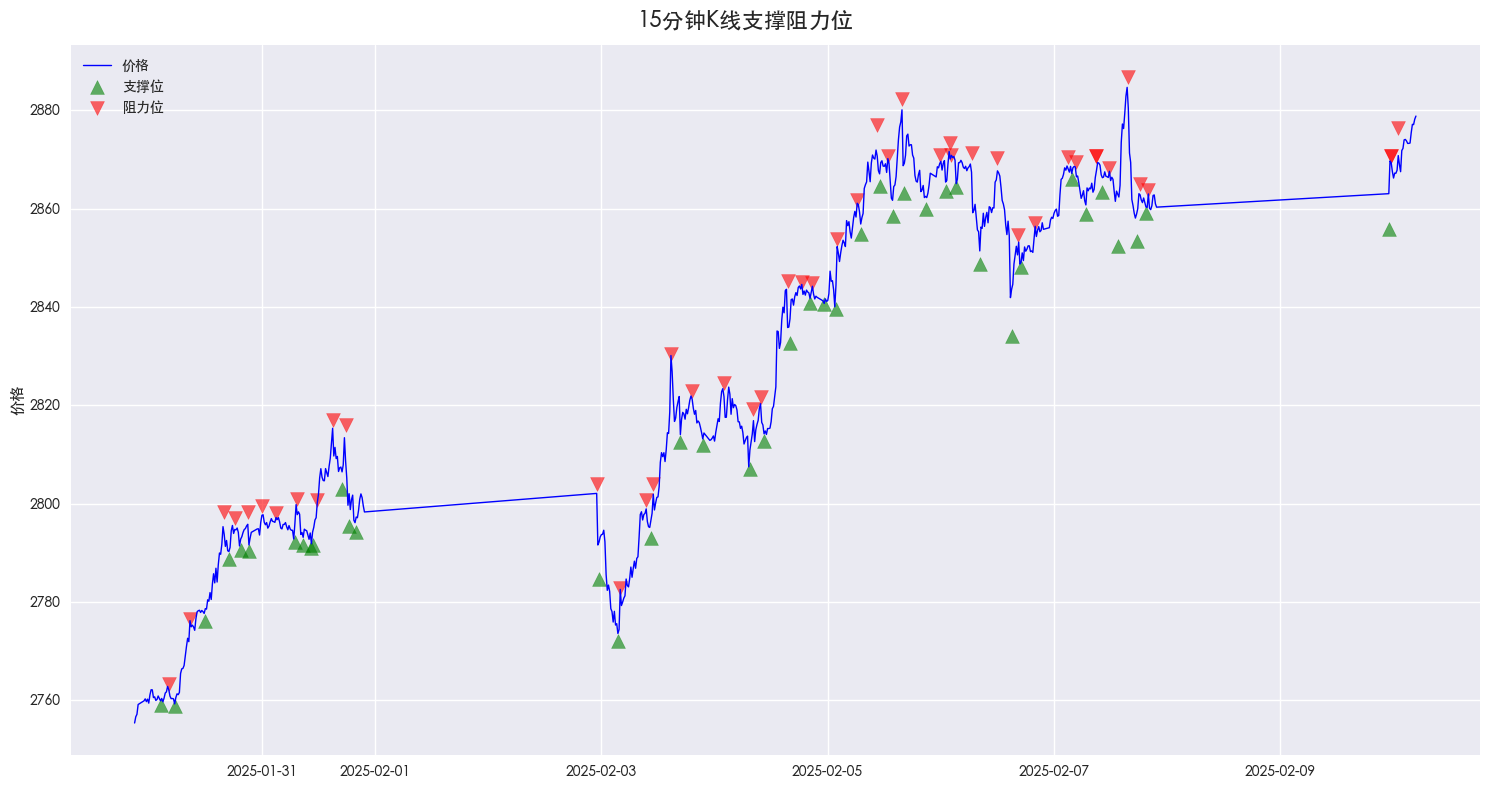

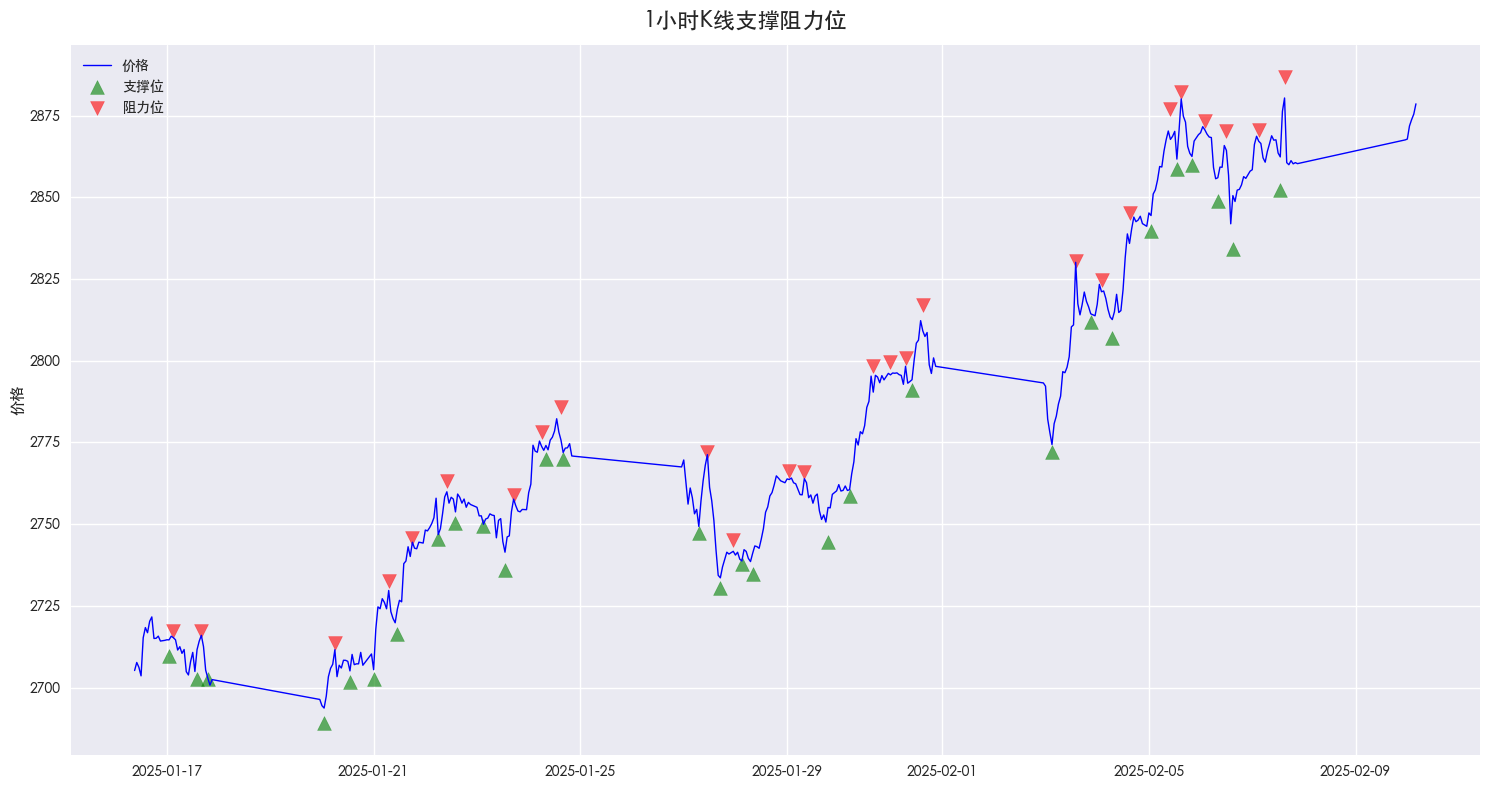

In [24]:
def plot_support_resistance(df, title, window=5, threshold=0.7):
    """
    绘制带有支撑位和阻力位的价格图表，使用点标注而不是水平线
    """
    # 计算支撑位和阻力位
    support_levels, resistance_levels = identify_dynamic_support_resistance(df, window=window, threshold=threshold)
    
    # 创建图表
    fig, ax = plt.subplots(figsize=(15, 8))
    fig.suptitle(title, fontsize=16)
    
    # 绘制价格线
    ax.plot(df.index, df['close'], label='价格', color='blue', linewidth=1)
    
    # 为支撑位和阻力位找到对应的时间点
    for level in support_levels:
        # 找到价格等于支撑位的所有时间点
        time_points = df.index[df['low'] == level]
        ax.scatter(time_points, [level] * len(time_points), 
                  color='g', marker='^', s=100, alpha=0.6, label='支撑位')
    
    for level in resistance_levels:
        # 找到价格等于阻力位的所有时间点
        time_points = df.index[df['high'] == level]
        ax.scatter(time_points, [level] * len(time_points), 
                  color='r', marker='v', s=100, alpha=0.6, label='阻力位')
    
    # 添加图例和标签（去除重复的图例）
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.set_ylabel('价格')
    ax.grid(True)
    
    # 优化布局
    plt.tight_layout()
    
    return fig

# 绘制15分钟数据的支撑阻力图
fig_15min = plot_support_resistance(df_15min, '15分钟K线支撑阻力位')

# 绘制1小时数据的支撑阻力图
fig_1h = plot_support_resistance(df_1h, '1小时K线支撑阻力位')

plt.show()

In [ ]:
import matplotlib 
matplotlib.matplotlib_fname()